In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add `Tangram` to path
sys.path.append("../") 

# Tangram imports
import mapping.library as ml

***
#### Download the data
- We will use [snRNA-seq data](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_P_allen.h5ad.gz) (adult mouse brain; MOp area).
- And one coronal slice of [Slide-seq2 data](
https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_cropped_DUAL.h5ad.gz) (adult mouse brain; MOp area).
- We will map them via a few hundred [marker genes](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv), [publicly available](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1) in literature.
- The two datasets should be unzipped. The two `h5ad` files and the `csv` file should be placed in the `data` folder.

***
#### Slide-seq data
- Slide-seq data contains 9852 spatial voxels, in each of which they measured 24518 genes.

In [2]:
path = os.path.join('data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

- We visualize the spatial ROI. Each "dot" is the center of a 10um voxel.

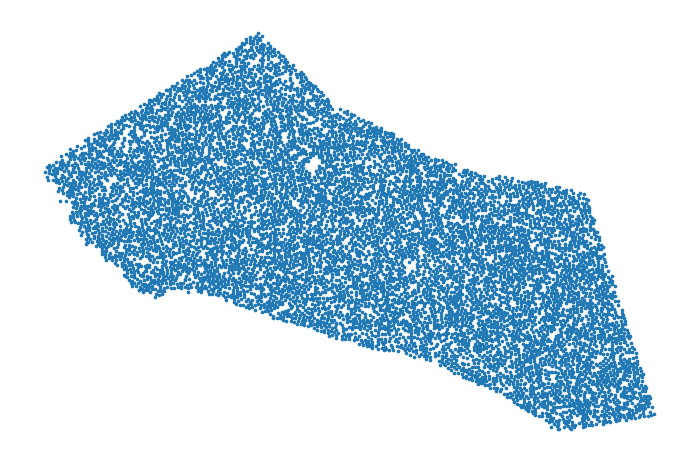

In [3]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);

***
#### Single cell data

- By single cell data, we mean either scRNAseq or snRNAseq.
- The following dataset contains single nuclei collected from a posterior region of the primary motor cortex.
- They are approximately 53k cells.

In [4]:
path = os.path.join('data','mop_P_allen.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

AnnData object with n_obs × n_vars = 52923 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [5]:
df_obs  = ad_sc.obs.sample(frac=.7)
ad_sc = ad_sc[df_obs.index, :].copy()

- Usually, we work with data in raw count form (but not necessarily), especially if the spatial data are in raw count form as well.
- If the data are in integer format, that probably means they are in raw count.

In [6]:
np.unique(ad_sc.X.toarray()[0, :])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  16.,  20.,  21.,  32.,  33.,  49.,  54.,
       144.], dtype=float32)

- We only do some light pre-processing such as library size correction (in scanpy, `sc.pp.normalize`).
- That normalize the number of count within each cell to a fixed number.
- Note that the resulting values might not be integer, still they quality as "count form".
- More sophisticated pre-processing is also possible, such as batch correction.
- Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible.

In [7]:
sc.pp.normalize_total(ad_sc)

- It is a good idea to have annotations in the single cell data, as they will be projected on space after we map.
- In this case, we use the `subclass_label` annotations which contain the cell type.
- Here we show a count

In [8]:
ad_sc.obs.subclass_label.value_counts()

L5 IT        7925
Oligo        6011
L2/3 IT      5036
L6 CT        4379
Astro        3664
Micro-PVM    1514
Pvalb        1372
L6 IT        1298
L5 ET        1256
Sst           899
L5/6 NP       892
Vip           580
L6b           506
Endo          476
Lamp5         453
VLMC          358
Peri          260
Sncg          123
Sst Chodl      35
Meis2           9
Name: subclass_label, dtype: int64

- For this mapping, we exclude cell types which are rare in the snRNAseq.
- Actually, Tangram can "reuse" the same cell multiple times because mapping is probabilistic.
- But for this case, we want Tangram to have "enough puzzle pieces" for each cell type.

In [9]:
rare_cts = ['Meis2', 'SMC', 'Sst Chodl']
mask = ~ad_sc.obs.subclass_label.isin(rare_cts)
ad_sc = ad_sc[mask, :]
ad_sc.obs.subclass_label.value_counts()

L5 IT        7925
Oligo        6011
L2/3 IT      5036
L6 CT        4379
Astro        3664
Micro-PVM    1514
Pvalb        1372
L6 IT        1298
L5 ET        1256
Sst           899
L5/6 NP       892
Vip           580
L6b           506
Endo          476
Lamp5         453
VLMC          358
Peri          260
Sncg          123
Name: subclass_label, dtype: int64

***
#### Prepare to map

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- Tangram restricts the search only to a set of genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types.
- For this case, we choose 253 marker genes of the MOp area which were curated [in a different study](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).

In [10]:
df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)
len(markers)

253

- We now need to prepare the datasets for mapping.
- The two `AnnData` structures need to be subset on the list of training genes.
- Second, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- This task is performed by the helper `prepare_adatas_cell_space`.

In [11]:
ad_sc, ad_sp = ml.prepare_adatas_cell_space(
    adata_cells=ad_sc, 
    adata_space=ad_sp, 
    marker_genes=markers
)

- You'll now notice that the two datasets now contain 252 genes, but 253 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `prepare_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `AnnData`s are actually ordered.

In [12]:
ad_sc

View of AnnData object with n_obs × n_vars = 37002 × 252
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [13]:
assert ad_sc.var.index.equals(ad_sp.var.index)

- At this point, it is a good to save the structures, then restart the python kernel.
- This is because we want to free as much memory as possible so that we can map.

In [14]:
ad_sc.write_h5ad('ad_sc_readytomap.h5ad')

In [15]:
ad_sp.write_h5ad('ad_sp_readytomap.h5ad')

***
#### Map

In [16]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add `Tangram` to path
sys.path.append("../") 

# Tangram imports
import mapping.mapping_utils as mu

In [17]:
ad_sp = sc.read_h5ad('ad_sp_readytomap.h5ad')
ad_sc = sc.read_h5ad('ad_sc_readytomap.h5ad')

- We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus (which can be controlled by passing the `num_epochs` parameter). 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data. 
- We obtained some excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- In the basic mapping version we do not use regularizers (hence the `NaN`). More sophisticated loss function can be used using the Tangram library.

In [ ]:
ad_map = mu.map_cells_to_space(
    adata_cells=ad_sc,
    adata_space=ad_sp,
)

Score: 0.102, KL reg: nan, VG reg: nan
Score: 0.788, KL reg: nan, VG reg: nan


- The mapping results are stored in an `AnnData` structure.
- The cell-by-spot matrix `X` contains the probability of cell $i$ to be in spot $j$.
- The `obs` dataframe contains the metadata of the single cells.
- The `var` dataframe contains the metadata of the spatial data.
- The `uns` dictionary contains the training genes (TODO)

In [5]:
ad_map.write_h5ad('ad_map.h5ad')

***
#### Analysis

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add `Tangram` to path
sys.path.append("../") 

# Tangram imports
import mapping.library as ml

In [2]:
ad_map = sc.read_h5ad('ad_map.h5ad')
ad_map

AnnData object with n_obs × n_vars = 36997 × 9852
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

- The main purpose of mapping is that we can transfer cell annotations, _ie_ contained in the `obs` dataframe in the single cell data, onto space.
- This is achieved by `project_cell_annotations` which returns a daframe with spatial probabilities for each annotations.
- The typical annotations are cell types, here found in the `subclass_label` field.

In [3]:
df_celltypes = ml.project_cell_annotations(ad_map, annotation='subclass_label')
df_celltypes.head()

,L5/6 NP,Pvalb,Micro-PVM,L5 IT,Sst,Astro,L2/3 IT,Oligo,L6 CT,Sncg,Lamp5,Vip,Endo,L6 IT,Peri,L5 ET,L6b,VLMC
0,0.618031,0.643166,5.692631,8.727040,0.076059,7.435911,1.487424,14.062815,1.927541,0.289650,0.000182,0.000952,0.000734,0.632309,0.000612,0.000552,0.000178,2.001177
1,2.466946,3.626513,11.205803,15.257423,2.988977,7.703093,13.631992,13.837777,6.353005,0.628901,2.377511,0.345112,2.827740,1.316448,2.058672,5.195047,1.238069,2.988276
2,0.998839,8.740320,2.533499,10.120195,0.186661,0.272064,1.100509,1.772514,5.353720,0.000185,1.172372,0.254423,0.738555,0.001211,0.381247,4.887962,0.000321,0.000215
3,0.000245,16.746644,2.108286,2.101986,0.640566,13.729706,0.005001,11.659179,0.475520,0.000143,0.000733,0.207595,0.574655,0.000539,0.138314,0.000855,0.059259,0.684034
4,0.000390,0.003655,2.761151,6.611165,0.001166,0.828465,1.828906,5.634473,5.793218,0.000189,0.000321,0.177063,1.226236,3.840021,0.011226,0.001217,1.395598,0.151816


- These annotations can then be processed or, plotted "by hand".
- We can also use the helper below to project the annotation and visualize the probability maps in space.

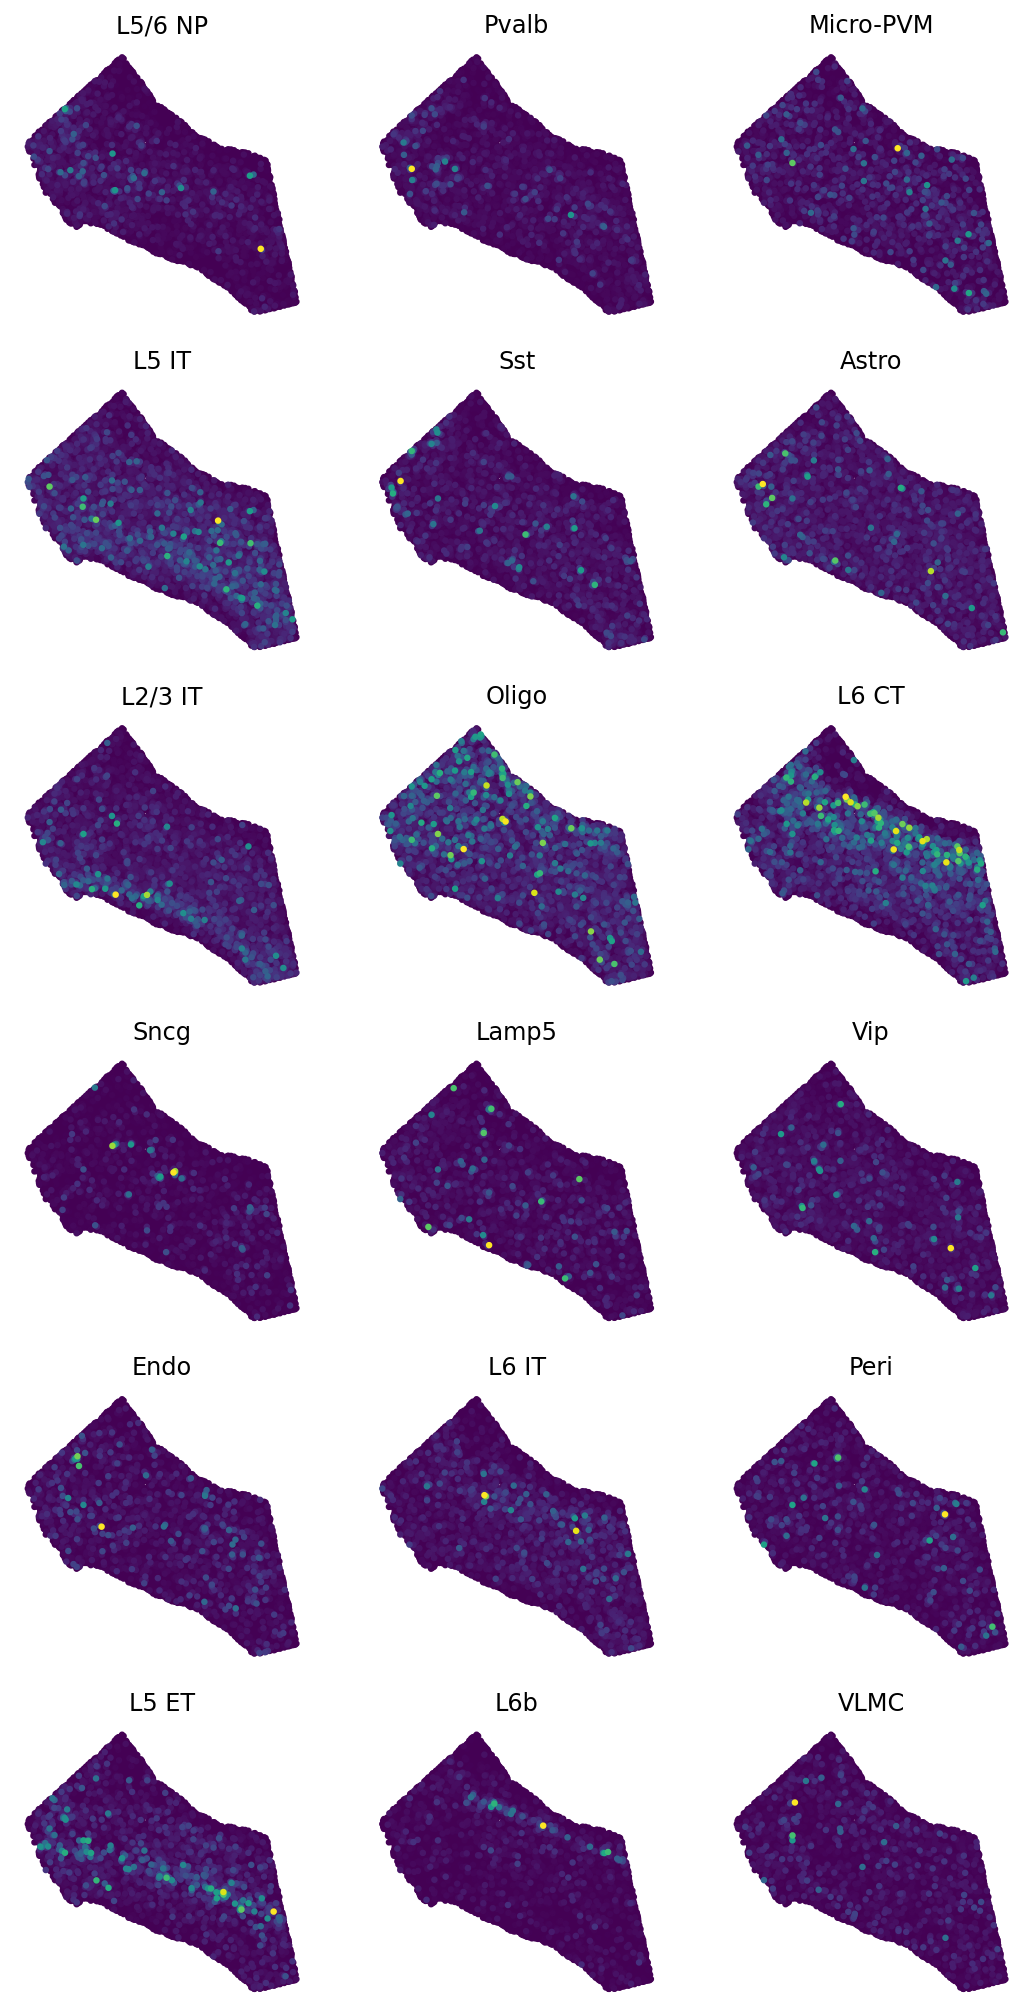

In [6]:
ml.plot_cell_annotation(ad_map, annotation='subclass_label', ncols=3, nrows=6)